In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import nltk
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from gensim.models import CoherenceModel

df = pd.read_csv("cleaned_reviews.csv")
nltk.download("wordnet")
nltk.download("vader_lexicon")





















In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
reviews = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")


In [ ]:

df = pd.DataFrame()
df["reviews"] = reviews

df = df[df['reviews'].notnull()]


df['reviews'] = df['reviews'].str.strip()
df['reviews'] = df['reviews'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

df["reviews"] = df["reviews"].str.replace(r"(trip verified|not verified)", "", flags=re.IGNORECASE, regex=True).str.strip()
df['reviews'] = df['reviews'].str.lower()
df = df.drop_duplicates()


print(df.head())  



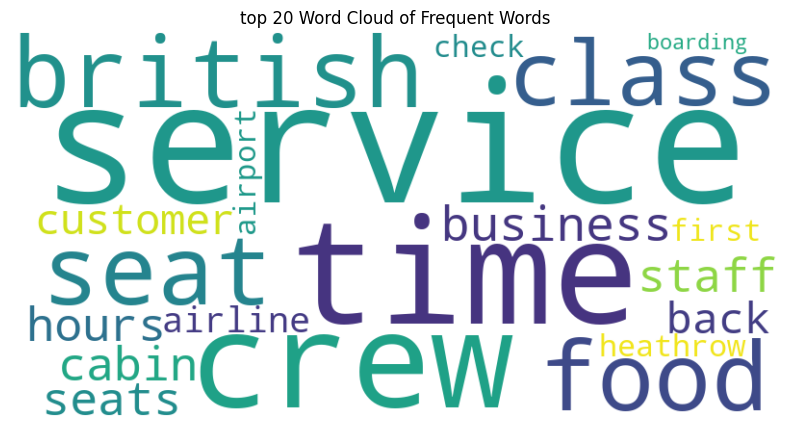

In [3]:
stop_words = set(stopwords.words("english"))
all_text = " ".join(df["reviews"].tolist()).split()
additional_stopwords = {"verified", "ba", "trip", "us", "london", "airways", "would", "get","good","told","even","flights","could","one", "flight"}
stop_words.update(additional_stopwords)
filtered_words = [word for word in all_text if word.lower() not in stop_words]
freq_word = Counter(filtered_words)

top_20_word = dict(freq_word.most_common(20))

words = list(top_20_word.keys()) 
frequencies = list(top_20_word.values()) 


wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_20_word)
plt.figure(figsize=(50, 5))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')  
plt.title("top 20 Word Cloud of Frequent Words")  
plt.show()  

# print(freq_word)
# print(type(freq_word))



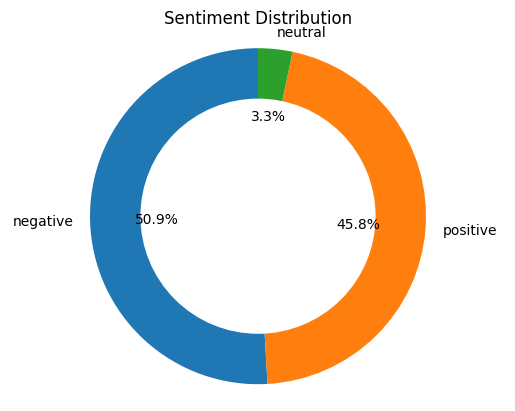

In [4]:

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)["compound"]


def label_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"


df["sentiment"] = df["reviews"].apply(get_sentiment)

df["sentiment_label"] = df["sentiment"].apply(label_sentiment).str.lower()

# Hitung distribusi sentiment
sentiment_counts = df["sentiment_label"].value_counts()

# Plot pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Sentiment Distribution")
plt.axis('equal')
plt.show()








In [ ]:
stop_words = set(stopwords.words("english"))
additional_stopwords = {
    "verified", "ba", "trip", "us", "london", "airways", "would", "get",
    "good", "told", "even", "flights", "could", "one", "flight"
}
stop_words.update(additional_stopwords) 
lemmatizer = WordNetLemmatizer()
all_reviews = df['reviews'].tolist()  

processed_reviews = []
for review in all_reviews:
    tokens = word_tokenize(review.lower())  
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    processed_reviews.append(filtered_tokens)

  
# print(filtered_tokens)

dictionary = corpora.Dictionary(processed_reviews)

corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# print(corpus)
# print(type(dictionary))

lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15, random_state=2)

topics = lda.print_topics(num_words=5)  
for topic in topics:
    print(topic)


In [ ]:
coherence_scores = []


for rs in range(1, 21):
    lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=5, random_state=rs)
    
   
    coherence_model_lda = CoherenceModel(model=lda, texts=processed_reviews, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    
    coherence_scores.append((rs, coherence_score))

for rs, score in coherence_scores:
    print(f"Random State {rs}: Coherence Score = {score}")


In [ ]:
top_topic_freq = Counter()

for bow in corpus:
    topics = lda.get_document_topics(bow)
    top_topic = max(topics, key=lambda x: x[1])[0]
    top_topic_freq[top_topic] += 1

print(top_topic_freq)

In [ ]:
topic_sentiment_count = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})


for i, bow in enumerate(corpus):
    sentiment = df.loc[i, 'sentiment_label']
    topics = lda.get_document_topics(bow)
    top_topic = max(topics, key=lambda x: x[1])[0]
    topic_sentiment_count[top_topic][sentiment] += 1


for topic, sentiment_counts in topic_sentiment_count.items():
    print(f"Topic {topic}: {sentiment_counts}")

In [ ]:
# df.to_csv('cleaned_reviews.csv', index=True)
